In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# add path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# parent_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(parent_dir)
# parent_dir

from src.utils import paths
from src.features import bispectrum
from src.features import powerspectra


In [2]:
seed = 50
redshift = 5

In [3]:
filename = paths.get_pre_computed_bispectra_from_bank(seed, "gr", redshift, type="equilateral")
filename

PosixPath('/mn/stornext/d10/data/johanmkr/simulations/data_analysis/pre_computed_bispectra_bank/seed0050_gr_equilateral_rs0005.csv')

In [4]:
grdF = pd.read_csv(paths.get_pre_computed_bispectra_from_bank(seed, "gr", redshift, type="equilateral"))
newtondF = pd.read_csv(paths.get_pre_computed_bispectra_from_bank(seed, "newton", redshift, type="equilateral"))
grdF.head()

,Unnamed: 0,k,B,Q
0,0,0.001227,-182758.014291,-9054.912783
1,1,0.001230,-167098.043610,-9855.823277
2,2,0.001232,-167098.043610,-9855.823277
3,3,0.001235,-167098.043610,-9855.823277
4,4,0.001238,-167098.043610,-9855.823277


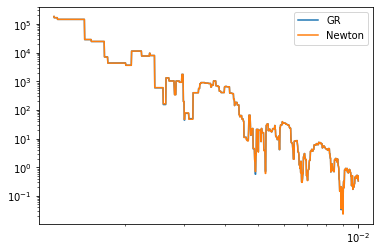

In [5]:
def plot_stuff(grdF, newtondF):
    plt.loglog(grdF["k"], abs(grdF["B"]), label="GR")
    plt.loglog(newtondF["k"], abs(newtondF["B"]), label="Newton")
    # plt.loglog(grdF["k"], grdF["B"], label="GR")
    # plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
    plt.legend()
    plt.show()

plot_stuff(grdF, newtondF)

In [6]:
# Naive rebinning

def naive_rebinning(frame:pd.DataFrame, bin_stride:int=5):
    """Rebin the bispectrum by averaging the values in each bin"""
    k = frame["k"]
    B = abs(frame["B"])
    k_rebinned = []
    B_rebinned = []
    i = 0
    while i < len(k):
        k_rebinned.append(k[i+bin_stride//2]) # Is this correct?
        B_rebinned.append(np.mean(B[i:i+bin_stride]))
        i += bin_stride
    return pd.DataFrame({"k":k_rebinned, "B":B_rebinned})


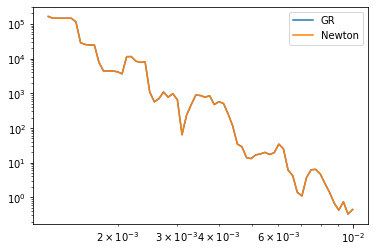

,k,B
0,0.001245,163873.127237
1,0.001285,145753.471519
2,0.001326,145753.471519
3,0.001369,145753.471519
4,0.001413,145753.471519
...,...,...
62,0.008779,0.682265
63,0.009060,0.426445
64,0.009350,0.744647
65,0.009649,0.328155


In [7]:
first_bin_stride = 15
once_rebinned_grdF = naive_rebinning(grdF, bin_stride=first_bin_stride)
once_rebinned_newtondF = naive_rebinning(newtondF, bin_stride=first_bin_stride)

plot_stuff(once_rebinned_grdF, once_rebinned_newtondF)
once_rebinned_grdF

In [8]:
# second_bin_stride = 5
# twice_rebinned_grdF = naive_rebinning(once_rebinned_grdF, bin_stride=second_bin_stride)
# twice_rebinned_newtondF = naive_rebinning(once_rebinned_newtondF, bin_stride=second_bin_stride)

# plot_stuff(twice_rebinned_grdF, twice_rebinned_newtondF)

In [9]:
# thirds_bin_stride = 5
# thrice_rebinned_grdF = naive_rebinning(twice_rebinned_grdF, bin_stride=thirds_bin_stride)
# thrice_rebinned_newtondF = naive_rebinning(twice_rebinned_newtondF, bin_stride=thirds_bin_stride)

# plot_stuff(thrice_rebinned_grdF, thrice_rebinned_newtondF)

# Analytical approach - three level PT


$$
    F_2(\mathbf{k}_1,\mathbf{k}_2) = \frac{5}{7} + \frac{x}{2}\left(\frac{k_1}{k_2}+\frac{k_2}{k_1}\right)+\frac{2}{7}x^2,
$$
with $x=\hat{\mathbf{k}}_1\cdot\hat{\mathbf{k}}_2 = \cos\theta$, where $\theta$ is the angle spanned by $\mathbf{k}_1$ and $\mathbf{k}_2$.

In [10]:
def F2_kernel(k1, k2, angle):
    return 5./7 + 1./2 * (k1/k2 + k2/k1) * np.cos(angle) + 2./7 * (np.cos(angle))**2

def full_F2_output(k, theta_12):
    """The F2 kernel for equilatera and squeezed triangles where k1=k2"""
    alpha = np.pi - theta_12
    k1 = k
    k2 = k
    k3 = np.sqrt(k1**2 + k2**2 - 2*k1*k2*np.cos(alpha))
    
    # Find beta and gamma
    beta = np.arcsin(k1/k3 * np.sin(alpha))
    gamma = np.arcsin(k2/k3 * np.sin(alpha))
    
    # Check that the angles add up to pi
    assert np.isclose(beta + gamma + alpha, np.pi)
    
    # Find remaining thetas
    theta_23 = np.pi - beta 
    theta_13 = np.pi - gamma
    
    # Permutations
    F12 = F2_kernel(k1, k2, theta_12)
    F23 = F2_kernel(k2, k3, theta_23)
    F31 = F2_kernel(k3, k1, theta_13)
    
    return F12, F23, F31, k3
    

In [11]:
grPS = powerspectra.PowerSpectra(paths.get_power_spectra_path(seed, "gr"))
newtonPS = powerspectra.PowerSpectra(paths.get_power_spectra_path(seed, "newton"))

In [12]:
# Spline spectra: 
from scipy import interpolate

def Splined_PS(PS, kind="cubic", **kwargs):
    """Returns a spline interpolation of the power spectra"""
    f = interpolate.interp1d(PS.k, PS.pk, kind=kind, **kwargs)
    return f

grPS_spline = Splined_PS(PS=grPS.get_power_spectrum("phi", redshift), bounds_error=False, fill_value ="extrapolate")
newtonPS_spline = Splined_PS(PS=newtonPS.get_power_spectrum("phi", redshift), bounds_error=False, fill_value ="extrapolate")

In [13]:
def analytical_equilateral_bispectrum(ps_function: callable):
    k_range = np.geomspace(1e-3, 1e-2, 100)
    B_analytical = []
    for k in k_range:
        F12, F23, F31, k3 = full_F2_output(k, 2*np.pi/3)
        B_value = 2 * F12 * ps_function(k) * ps_function(k) + 2*F23 * ps_function(k) * ps_function(k3) + 2*F31 * ps_function(k) * ps_function(k3)
        # FIXME why divide by k here
        B_analytical.append(B_value/k) # why divide by k here
        # print(B_value*1e7)
    return k_range, B_analytical

def analytical_squeezed_bispectrum(ps_function: callable):
    k_range = np.geomspace(1e-3, 1e-2, 100)
    B_analytical = []
    for k in k_range:
        F12, F23, F31, k3 = full_F2_output(k, 20*np.pi/19)
        B_value = 2 * F12 * ps_function(k) * ps_function(k) + 2*F23 * ps_function(k) * ps_function(k3) + 2*F31 * ps_function(k) * ps_function(k3)
        B_analytical.append(B_value)
    return k_range, B_analytical

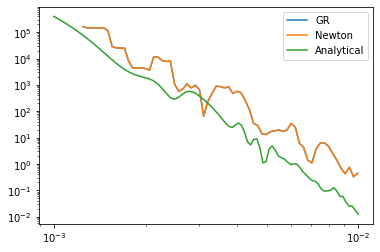

In [14]:
k_anal, B_anal = analytical_equilateral_bispectrum(grPS_spline)


plt.loglog(once_rebinned_grdF["k"], abs(once_rebinned_grdF["B"]), label="GR")
plt.loglog(once_rebinned_newtondF["k"], abs(once_rebinned_newtondF["B"]), label="Newton")
plt.loglog(k_anal, B_anal, label="Analytical")
# plt.loglog(grdF["k"], grdF["B"], label="GR")
# plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
plt.legend()
plt.show()

# Using the power spectra of $\Phi$ from CLASS

In [15]:
from src.features import classPK

def get_potential_power_spectrum_spline(z):
    class_obj = classPK.ClassSpectra(redshift=z)
    phi_frame = class_obj.phi_pk
    f = interpolate.interp1d(phi_frame.k, phi_frame.pk, kind="cubic", bounds_error=False, fill_value ="extrapolate")
    return f

phi_spline = get_potencube.Cubetial_power_spectrum_spline(redshift)


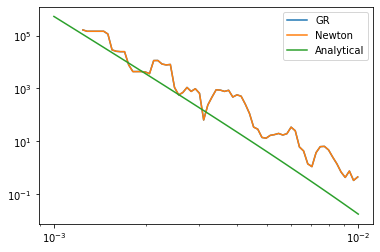

In [16]:
k_anal, B_anal = analytical_equilateral_bispectrum(phi_spline)


plt.loglog(once_rebinned_grdF["k"], abs(once_rebinned_grdF["B"]), label="GR")
plt.loglog(once_rebinned_newtondF["k"], abs(once_rebinned_newtondF["B"]), label="Newton")
plt.loglog(k_anal, B_anal, label="Analytical")
# plt.loglog(grdF["k"], grdF["B"], label="GR")
# plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
plt.legend()
plt.show()

# More analytical approach  NBNB: DOES NOT WORK ON HORIZON SCALE

Since the above we use the power spectra from the datacubes itself, which induces a bias. Furthermore, each realisation (seed) give rise to a different power spectrum. 

In the below approach I try to make it more analytical:


Start from Poisson equation: 

$$
    \Phi(k,a) = \frac{3\Omega_m H_0^2}{2k^2 a}\delta_m(k,a)   \;\;\;\text{(Dodelson 2020, eq8.6)}
$$

Then find the power spectrum through:

$$
    \langle\Phi(\mathbf{k},a)\Phi^*(\mathbf{k},a)\rangle = \mathcal{P}_\Phi(k,a)(2\pi)^3\delta_D(\mathbf{k}-\mathbf{k}') \\
    \\
    \implies \mathcal{P}_\Phi(k,a)\delta_D(\mathbf{k}-\mathbf{k}') =  \frac{\langle\Phi(\mathbf{k},a)\Phi^*(\mathbf{k},a)\rangle}{(2\pi)^3}
$$
which again implies:

$$
    \mathcal{P}_\Phi(k,a) = \left( \frac{3}{2}\frac{\Omega_m H_0^2}{k^2 a} \right)^2 \mathcal{P}_\delta(k,a)
$$

which for the redshift become:

$$
    \mathcal{P}_\Phi(k,z) = \left(\frac{3}{2} \frac{\Omega_m H_0^2(1+z)}{k^2} \right)^2 \mathcal{P}_\delta(k,z)
$$

I use the following values for $\Omega_m$ and $H_0$:

* $H_0 = 67.556$
* $\Omega_m = \Omega_b + \Omega_c = 0.022032 + 0.12038 $

In [17]:
# # Matter power spectrum spline
# from src.features import classPK

# def matter_power_spectrum_spline(z):
#     class_matter_PS = classPK.ClassSpectra()
#     class_matter_PS_results = class_matter_PS(z, gauge="synchronous")
#     k = class_matter_PS_results[0]
#     pk = class_matter_PS_results[1]
#     f = interpolate.interp1d(k, pk, kind="cubic", bounds_error=False, fill_value ="extrapolate")
#     return f

# mpsp = matter_power_spectrum_spline(redshift)

In [18]:
# H0 = 67.556
# h = H0/100
# Omega_m = 0.022032 + 0.12038

# def PS_phi_analytical(k:float, z:float = redshift, ps: callable=mpsp):
#     """Analytical expression for the power spectrum of phi"""
#     copilot_suggestion = 2*np.pi**2 * (H0/2/np.pi)**4 * (k**3)**(3/2) * (1 + z)**2 / (Omega_m)**2
#     # FIXME: This is not correct
#     my_analytical_answer =  (3./2 * Omega_m * H0**2 * (1+z)/k**2)**2 * ps(k)
#     k = k/h
#     a = 1 / (1 + z)
#     prefactor = (9./4) * (H0**4/k**4) * (Omega_m**2) * (a**4)
#     chatGPT_answer = prefactor * ps(k)
    
#     return ps(k)

In [19]:
# k = np.geomspace(1e-3, 1, 100)
# plt.loglog(k, PS_phi_analytical(k), label="Analytical")

In [20]:
# # Compare with actual power spectra:
# from src.features import powerspectra

# PowerSpectra = powerspectra.PowerSpectra(paths.get_power_spectra_path(seed, "gr"))

In [21]:
# k_anal, B_anal = analytical_equilateral_bispectrum(PS_phi_analytical)


# # plt.loglog(once_re_rebinned_grdF["k"], abs(once_rebinned_grdF["B"]), label="GR")
# # plt.loglog(oncebinned_newtondF["k"], abs(once_rebinned_newtondF["B"]), label="Newton")
# plt.loglog(k_anal, B_anal, label="Analytical")
# # plt.loglog(grdF["k"], grdF["B"], label="GR")
# # plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
# plt.legend()
# plt.show()